In [1]:
# Cell 1: Load Saved Data
import pandas as pd
import numpy as np
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = os.path.join('..', 'data')

with open(os.path.join(DATA_DIR, 'price_data.pkl'), 'rb') as f:
    price_data = pickle.load(f)

with open(os.path.join(DATA_DIR, 'financial_data.pkl'), 'rb') as f:
    financial_data = pickle.load(f)

with open(os.path.join(DATA_DIR, 'tickers.pkl'), 'rb') as f:
    tickers = pickle.load(f)

print(f'Loaded {len(price_data)} price datasets')
print(f'Loaded {len(financial_data)} financial datasets')
print(f'Tickers: {len(tickers)}')

# Show available metrics for first company
sample = financial_data[0]
print(f'\nSample: {sample["ticker"]}')
print(f'Income metrics: {list(sample["quarterly_income"].index)}')
print(f'Balance metrics: {list(sample["quarterly_balance"].index)}')
print(f'Quarters: {sample["quarterly_income"].shape[1]}')

Loaded 49 price datasets
Loaded 46 financial datasets
Tickers: 46

Sample: AAPL
Income metrics: ['Total Revenue', 'Cost of Revenue', 'Gross Profit', 'Operating Income', 'Net Income', 'EPS Basic', 'EPS Diluted', 'R&D Expense', 'SGA Expense', 'Interest Expense', 'Income Tax']
Balance metrics: ['Total Assets', 'Current Assets', 'Total Liabilities', 'Current Liabilities', 'Long Term Debt', 'Short Term Debt', 'Stockholders Equity', 'Cash', 'Shares Outstanding', 'Operating Cash Flow', 'Capital Expenditures']
Quarters: 53


In [2]:
# Cell 2: Feature Engineering Function

def safe_loc(df, metric, quarter):
    """Safely get value from DataFrame using .loc[metric, quarter]."""
    try:
        if metric in df.index and quarter in df.columns:
            val = df.loc[metric, quarter]
            if pd.notna(val):
                return float(val)
    except:
        pass
    return np.nan

def safe_divide(a, b):
    """Safely divide, returning NaN for zero/NaN denominators."""
    if pd.isna(a) or pd.isna(b) or b == 0:
        return np.nan
    return a / b

def safe_growth(current, previous):
    """Calculate growth rate, returning NaN if either value is missing."""
    if pd.isna(current) or pd.isna(previous) or previous == 0:
        return np.nan
    return (current - previous) / abs(previous)

def create_features(financial_data, price_data):
    """Create 30+ ML features from SEC financial data and stock prices."""
    all_samples = []
    skipped = {'no_revenue': 0, 'no_price': 0, 'no_future_price': 0}

    for company in financial_data:
        ticker = company['ticker']
        income = company.get('quarterly_income')
        balance = company.get('quarterly_balance')

        if income is None or income.empty:
            continue
        if ticker not in price_data:
            continue

        ticker_prices = price_data[ticker]['Adj Close']
        quarters = list(income.columns)

        for i in range(len(quarters) - 1):
            q = quarters[i]
            q_prev = quarters[i + 1]  # Next chronological quarter for growth

            # === Raw metrics from income statement ===
            revenue = safe_loc(income, 'Total Revenue', q)
            cost_of_rev = safe_loc(income, 'Cost of Revenue', q)
            gross_profit = safe_loc(income, 'Gross Profit', q)
            operating_income = safe_loc(income, 'Operating Income', q)
            net_income = safe_loc(income, 'Net Income', q)
            eps_basic = safe_loc(income, 'EPS Basic', q)
            eps_diluted = safe_loc(income, 'EPS Diluted', q)
            rd_expense = safe_loc(income, 'R&D Expense', q)
            sga_expense = safe_loc(income, 'SGA Expense', q)
            interest_expense = safe_loc(income, 'Interest Expense', q)
            income_tax = safe_loc(income, 'Income Tax', q)

            # Previous quarter for growth
            prev_revenue = safe_loc(income, 'Total Revenue', q_prev)
            prev_net_income = safe_loc(income, 'Net Income', q_prev)
            prev_operating_income = safe_loc(income, 'Operating Income', q_prev)
            prev_eps = safe_loc(income, 'EPS Diluted', q_prev)

            # Skip if no revenue
            if pd.isna(revenue) or revenue == 0:
                skipped['no_revenue'] += 1
                continue

            # === Raw metrics from balance sheet / cash flow ===
            total_assets = safe_loc(balance, 'Total Assets', q) if balance is not None else np.nan
            current_assets = safe_loc(balance, 'Current Assets', q) if balance is not None else np.nan
            total_liabilities = safe_loc(balance, 'Total Liabilities', q) if balance is not None else np.nan
            current_liabilities = safe_loc(balance, 'Current Liabilities', q) if balance is not None else np.nan
            long_term_debt = safe_loc(balance, 'Long Term Debt', q) if balance is not None else np.nan
            short_term_debt = safe_loc(balance, 'Short Term Debt', q) if balance is not None else np.nan
            equity = safe_loc(balance, 'Stockholders Equity', q) if balance is not None else np.nan
            cash = safe_loc(balance, 'Cash', q) if balance is not None else np.nan
            shares_out = safe_loc(balance, 'Shares Outstanding', q) if balance is not None else np.nan
            op_cash_flow = safe_loc(balance, 'Operating Cash Flow', q) if balance is not None else np.nan
            capex = safe_loc(balance, 'Capital Expenditures', q) if balance is not None else np.nan

            # Total debt
            total_debt = np.nan
            if pd.notna(long_term_debt) and pd.notna(short_term_debt):
                total_debt = long_term_debt + short_term_debt
            elif pd.notna(long_term_debt):
                total_debt = long_term_debt

            # Free cash flow
            free_cash_flow = np.nan
            if pd.notna(op_cash_flow) and pd.notna(capex):
                free_cash_flow = op_cash_flow - capex

            # === Match stock prices ===
            quarter_end = pd.Timestamp(q)

            mask = (ticker_prices.index >= quarter_end - pd.Timedelta(days=7)) & \
                   (ticker_prices.index <= quarter_end + pd.Timedelta(days=7))
            if not mask.any():
                skipped['no_price'] += 1
                continue
            quarter_price = float(ticker_prices[mask].iloc[0])

            future_date = quarter_end + pd.Timedelta(days=90)
            mask_future = (ticker_prices.index >= future_date - pd.Timedelta(days=7)) & \
                          (ticker_prices.index <= future_date + pd.Timedelta(days=7))
            if not mask_future.any():
                skipped['no_future_price'] += 1
                continue
            future_price = float(ticker_prices[mask_future].iloc[0])

            target_return = (future_price - quarter_price) / quarter_price

            # === Compute derived features ===
            market_cap = shares_out * quarter_price if pd.notna(shares_out) else np.nan

            sample = {
                'ticker': ticker,
                'date': q,
                # Price
                'quarter_price': quarter_price,
                # Profitability ratios
                'revenue': revenue,
                'revenue_growth': safe_growth(revenue, prev_revenue),
                'gross_margin': safe_divide(gross_profit, revenue),
                'profit_margin': safe_divide(net_income, revenue),
                'operating_margin': safe_divide(operating_income, revenue),
                'net_income': net_income,
                'net_income_growth': safe_growth(net_income, prev_net_income),
                'operating_income_growth': safe_growth(operating_income, prev_operating_income),
                # Per-share
                'eps_diluted': eps_diluted,
                'eps_growth': safe_growth(eps_diluted, prev_eps),
                # Expense ratios
                'rd_ratio': safe_divide(rd_expense, revenue),
                'sga_ratio': safe_divide(sga_expense, revenue),
                'tax_rate': safe_divide(income_tax, operating_income),
                # Balance sheet ratios
                'total_assets': total_assets,
                'debt_to_assets': safe_divide(total_debt, total_assets),
                'debt_to_equity': safe_divide(total_debt, equity),
                'current_ratio': safe_divide(current_assets, current_liabilities),
                'cash_ratio': safe_divide(cash, current_liabilities),
                'equity_ratio': safe_divide(equity, total_assets),
                # Returns on capital
                'roa': safe_divide(net_income, total_assets),
                'roe': safe_divide(net_income, equity),
                # Efficiency
                'asset_turnover': safe_divide(revenue, total_assets),
                'interest_coverage': safe_divide(operating_income, interest_expense),
                # Cash flow
                'operating_cash_flow': op_cash_flow,
                'free_cash_flow': free_cash_flow,
                'fcf_margin': safe_divide(free_cash_flow, revenue),
                # Valuation
                'market_cap': market_cap,
                'pe_ratio': safe_divide(quarter_price, eps_diluted) if pd.notna(eps_diluted) and eps_diluted > 0 else np.nan,
                'price_to_book': safe_divide(market_cap, equity),
                # Target
                'target_return': target_return,
            }
            all_samples.append(sample)

    print(f'Skipped: {skipped}')
    return pd.DataFrame(all_samples)

print('Feature engineering function defined (30+ features)')

Feature engineering function defined (30+ features)


In [3]:
# Cell 3: Create Feature Dataset
print('Creating feature dataset...')

dataset = create_features(financial_data, price_data)

print(f'\nCreated dataset with {len(dataset)} samples')
print(f'Dataset shape: {dataset.shape}')
print(f'Features: {len(dataset.columns) - 3} (excluding ticker, date, target_return)')
print(f'\nCompanies: {dataset["ticker"].nunique()}')
print(f'\nSamples per company:')
print(dataset['ticker'].value_counts().to_string())

if len(dataset) > 0:
    print(f'\nFirst few rows:')
    print(dataset.head())

Creating feature dataset...
Skipped: {'no_revenue': 1011, 'no_price': 1054, 'no_future_price': 6}

Created dataset with 192 samples
Dataset shape: (192, 33)
Features: 30 (excluding ticker, date, target_return)

Companies: 32

Samples per company:
ticker
IBM      15
UNH      15
GE       15
CAT      15
NVDA     15
BA       15
NFLX     15
ADBE     15
BAC      15
MCD      15
JPM       6
ABT       3
GOOGL     3
ABBV      3
AXP       3
WFC       3
SPGI      2
MRK       2
TMO       2
MDT       2
PFE       2
JNJ       1
CSCO      1
AMZN      1
HON       1
INTC      1
WMT       1
ORCL      1
HD        1
KO        1
PG        1
MSFT      1

First few rows:
  ticker       date  quarter_price       revenue  revenue_growth  \
0   MSFT 2017-09-30          73.26  2.453800e+10       -0.151463   
1  GOOGL 2017-03-31         835.14  2.475000e+10       -0.048443   
2  GOOGL 2017-06-30         986.09  2.601000e+10       -0.063445   
3  GOOGL 2017-09-30         934.28  2.777200e+10       -0.108329   
4   A

In [4]:
# Cell 4: Data Cleaning

print(f'Original dataset: {len(dataset)} samples, {dataset.shape[1]} columns')

# Check missing values per feature
feature_cols = [c for c in dataset.columns if c not in ['ticker', 'date', 'target_return']]
missing_pct = dataset[feature_cols].isna().mean().sort_values(ascending=False)
print(f'\nMissing values per feature:')
for col, pct in missing_pct.items():
    bar = '#' * int(pct * 30)
    print(f'  {col:<25s} {pct:>6.1%} {bar}')

# Remove features with >60% missing
high_missing = missing_pct[missing_pct > 0.60].index.tolist()
if high_missing:
    print(f'\nDropping features with >60% missing: {high_missing}')
    dataset = dataset.drop(columns=high_missing)

# Remove extreme target returns (>100%)
dataset = dataset[dataset['target_return'].between(-1, 1)]
print(f'After removing extreme returns: {len(dataset)} samples')

# Remove infinite values
dataset = dataset.replace([np.inf, -np.inf], np.nan)

# Fill remaining NaN with 0 for ratio features
feature_cols = [c for c in dataset.columns if c not in ['ticker', 'date', 'target_return']]
dataset[feature_cols] = dataset[feature_cols].fillna(0)

# Remove rows where revenue is 0 or negative
dataset = dataset[dataset['revenue'] > 0]
print(f'After cleaning: {len(dataset)} samples')

remaining_features = [c for c in dataset.columns if c not in ['ticker', 'date', 'target_return']]
print(f'Final features: {len(remaining_features)}')
print(f'Companies: {dataset["ticker"].nunique()}')

# Save
dataset.to_csv(os.path.join(DATA_DIR, 'processed_dataset.csv'), index=False)
print(f'\nSaved to data/processed_dataset.csv')

Original dataset: 192 samples, 33 columns

Missing values per feature:
  fcf_margin                 66.1% ###################
  free_cash_flow             66.1% ###################
  gross_margin               64.1% ###################
  operating_cash_flow        62.5% ##################
  price_to_book              57.3% #################
  rd_ratio                   55.2% ################
  interest_coverage          48.4% ##############
  debt_to_equity             47.9% ##############
  market_cap                 45.8% #############
  debt_to_assets             43.2% ############
  sga_ratio                  33.3% ##########
  operating_income_growth    30.7% #########
  tax_rate                   30.2% #########
  operating_margin           30.2% #########
  cash_ratio                 29.7% ########
  current_ratio              21.9% ######
  roe                        18.2% #####
  roa                        13.5% ####
  net_income                 13.5% ####
  profit_margin     

In [5]:
# Cell 5: Feature Statistics

feature_cols = [c for c in dataset.columns if c not in ['ticker', 'date', 'target_return']]

print(f'=== Dataset Summary ===')
print(f'Samples: {len(dataset)}')
print(f'Companies: {dataset["ticker"].nunique()}')
print(f'Features: {len(feature_cols)}')
print(f'\nTarget (quarterly return):')
print(f'  Mean: {dataset["target_return"].mean():.4f}')
print(f'  Std:  {dataset["target_return"].std():.4f}')
print(f'  Min:  {dataset["target_return"].min():.4f}')
print(f'  Max:  {dataset["target_return"].max():.4f}')

print(f'\nFeature statistics:')
print(dataset[feature_cols].describe().T[['mean', 'std', 'min', 'max']].to_string())

=== Dataset Summary ===
Samples: 192
Companies: 32
Features: 26

Target (quarterly return):
  Mean: 0.0722
  Std:  0.1313
  Min:  -0.3031
  Max:  0.6139

Feature statistics:
                                 mean           std           min           max
quarter_price            1.052501e+02  1.313288e+02  1.230000e+01  9.860900e+02
revenue                  1.621032e+10  1.449801e+10  9.547390e+08  1.221360e+11
revenue_growth          -1.949398e-02  7.606672e-02 -2.874251e-01  2.236366e-01
profit_margin            1.058182e-01  1.030121e-01 -5.172834e-01  3.273381e-01
operating_margin         1.105375e-01  1.180317e-01 -3.820047e-02  5.351197e-01
net_income               1.381977e+09  2.019663e+09 -1.357300e+10  6.732000e+09
net_income_growth        5.484694e-01  3.757524e+00 -8.980147e+00  3.575000e+01
operating_income_growth -1.138838e-02  4.844753e-01 -1.626943e+00  5.267303e+00
eps_diluted              1.123594e+00  1.220499e+00 -1.350000e+00  9.570000e+00
eps_growth               1

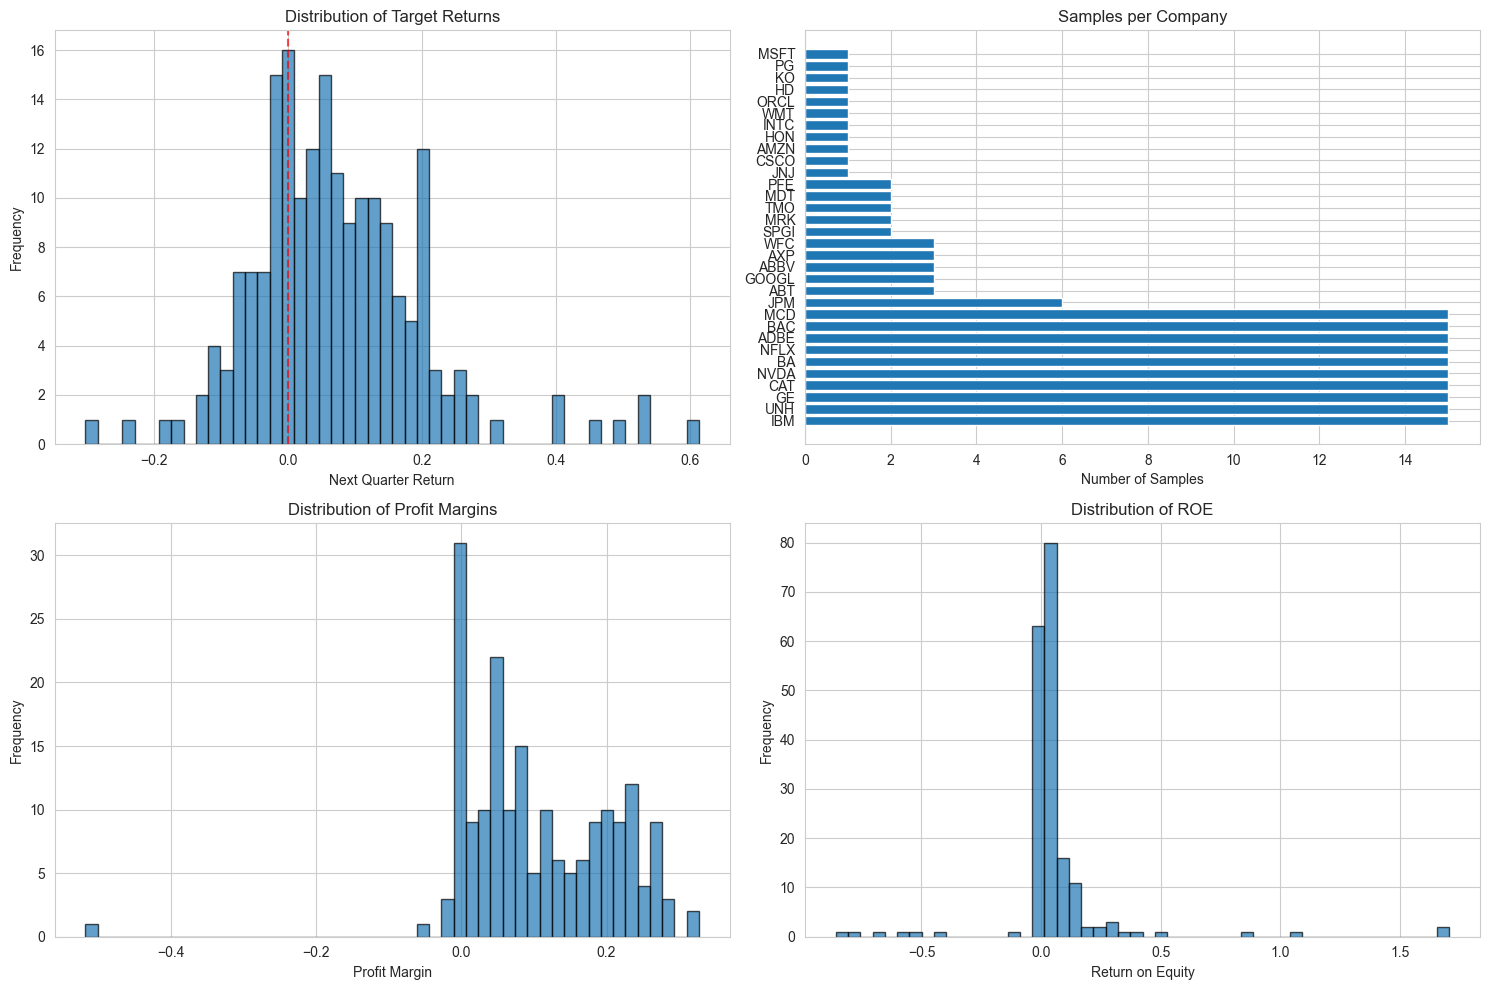

Saved visualization to results/data_exploration.png


In [6]:
# Cell 6: Data Exploration
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Target return distribution
axes[0, 0].hist(dataset['target_return'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Next Quarter Return')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Target Returns')
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7)

# 2. Samples per company
samples_per_company = dataset['ticker'].value_counts()
axes[0, 1].barh(samples_per_company.index, samples_per_company.values)
axes[0, 1].set_xlabel('Number of Samples')
axes[0, 1].set_title('Samples per Company')

# 3. Profit margin distribution
axes[1, 0].hist(dataset['profit_margin'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Profit Margin')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Profit Margins')

# 4. ROE distribution
roe_clean = dataset['roe'][dataset['roe'].between(-2, 2)]
axes[1, 1].hist(roe_clean, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Return on Equity')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of ROE')

plt.tight_layout()
plt.savefig(os.path.join('..', 'results', 'data_exploration.png'), dpi=150, bbox_inches='tight')
plt.show()

print('Saved visualization to results/data_exploration.png')